# Bootstrap used for Error estimation

Given a best guess at the parameters $\phi$ and $\delta t$ use resampling with replacement of the seismic data to bootstrap the covariance matrix.

From this we can calculate distributions of the eigenvectors, eigenvalues, and pearson correlation coefficients, which can be used to estimate the errors in the source polarisation and the splitting parameters (according to the Silver and Chan method, as well as the cross-correlation method).

How to chose the best guess parameters?  One idea would be to run the grid search and use the parameters that minimise $\lambda_2$, or to chose the parameters that maximise $\rho$.  If each approach is equally valid then some kind of joint solution may be derived by 

In [3]:
%load_ext autoreload
%autoreload 2

import splitwavepy as sw

import numpy as np
import matplotlib.pyplot as plt

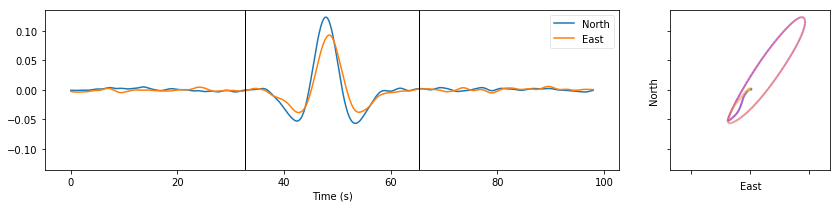

In [20]:
a = sw.SplitWave(split=(30,2), noise=0.01, pol=40).Py()
a._data.plot()
x = a._data.x
y = a._data.y

In [102]:
def wrap_split(x, y, rotate, dt, delta):
    x, y = sw.core.core.rotate(x, y, rotate)
    shift = sw.core.core.time2samps(dt, delta)
    y = np.roll(y, shift)
#     x, y = sw.core.core.rotate(x, y, -rotate)
    return x, y



def bootcov(x, y, n=200):
    """Resample x, y data and return n bootstrap covariance matrices."""
    
    # prep data with taper to window, rotate, 
    # and lag with wrap around (to replicate process in fourier domain)    
    bscov = np.empty((n, 2, 2))
    
    for ii in range(n):
        bsx, bsy = sw.core.core.bootstrap_resamp(x, y)
        bscov[ii] = np.cov(bsx, bsy, bias=True)
        
    return bscov
        
        
        
        

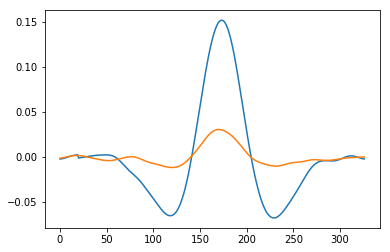

In [38]:
chp = a._data.chop()
x, y = chp.x, chp.y
sx, sy = wrap_unsplit(x, y, 30, 2, a._data._delta)
plt.plot(sx)
plt.plot(sy)
plt.show()

In [82]:
gcov = sw.core.core.gridcovfreq(sx, sy)
gcov[0][0]

array([[ 0.0029745 , -0.00023806],
       [-0.00023806,  0.0001074 ]])

In [123]:
x, y = a._data.x, a._data.y
b = bootcov(x, y, n=20000)

In [85]:
# np.var(sx)
# dx = sx - np.mean(sx)
# (np.sum(dx*dx))/dx.size
cov = np.cov(sx, sy, bias=True)
cov
# np.linalg.eigh(cov)
# np.sum(sx*sx)

array([[0.0029745 , 0.00055492],
       [0.00055492, 0.0001074 ]])

In [84]:
dy = sy - np.mean(sy)
np.sum(dx*dy)/dx.size

0.0005549183499493738

In [110]:
def mycov(x, y):
    c = np.empty((2,2))
    n = x.size
    dx = x - np.mean(x)
    dy = y - np.mean(y)
    c[0][0] = np.sum(dx*dx)
    c[1][1] = np.sum(dy*dy)
    c[0][1] = c[1][0] = np.sum(dx*dy)
    return c / n

mycov(sx, sy) - np.cov(sx, sy, bias=True)
%timeit mycov(sx, sy)
%timeit np.cov(sx, sy, bias=True)

The slowest run took 4.27 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 31.2 µs per loop
The slowest run took 5.08 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 35.9 µs per loop


In [74]:
# eig = np.linalg.eigh(gcov[0,0])[0]
# eig[0]**2 + eig[1]**2

8.97255034667355e-06

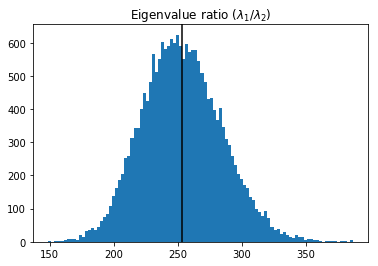

In [160]:
plt.close()
rat = evals[:,1]/evals[:,0]
plt.hist(rat, bins=100)
plt.axvline(np.mean(rat), color='k')
plt.title('Eigenvalue ratio ($\lambda_1/\lambda_2$)')
plt.show()

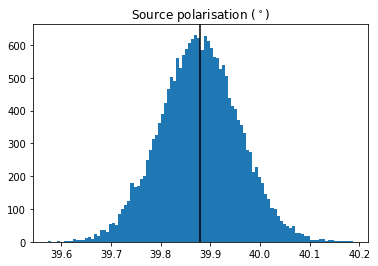

In [163]:

# evec1 = evecs[0,:,1]
# (np.rad2deg(np.arctan2(evec1[1],evec1[0]))+180)
angs = (np.rad2deg(np.arctan2(evecs[:,1,1], evecs[:,0,1]))+3690)%180-90
plt.hist(angs, bins=100)
plt.axvline(np.mean(angs), color='k')
plt.title('Source polarisation ($^\circ$)')
plt.show()

In [148]:
def covmap2rho(cov):
    stdx = np.sqrt(cov[:, 0, 0])
    stdy = np.sqrt(cov[:, 1, 1])
    rho = cov[:, 0, 1] / (stdx * stdy)
    return rho

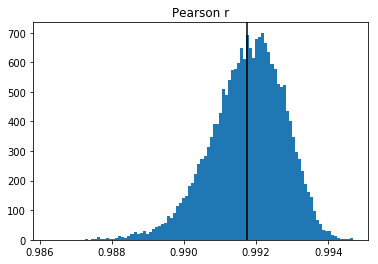

In [165]:
rho = covmap2rho(b)
plt.hist(rho, bins=100)
plt.axvline(np.mean(rho), color='k')
plt.title('Pearson r')
plt.show()

In [166]:
np.percentile(rho,0.05)

0.9874650841055526

In [3]:
from arch import bootstrap

In [32]:
bs = bootstrap.StationaryBootstrap(50, x=x, y=y)
for data in bs.bootstrap(1):
    bsx = data


In [19]:
>>> from arch.bootstrap import StationaryBootstrap
>>> from numpy.random import standard_normal
>>> y = standard_normal((500, 1))
>>> x = standard_normal((500,2))
>>> z = standard_normal(500)
>>> bs = StationaryBootstrap(12, x, y=y, z=z)
>>> for data in bs.bootstrap(100):
...     bs_x = data[0][0]
...     bs_y = data[1]['y']
...     bs_z = bs.z

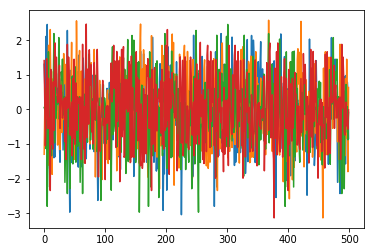

In [24]:
plt.plot(x)
plt.plot(bs_x)
plt.show()

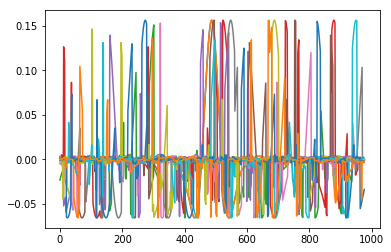

In [77]:
bs = bootstrap.StationaryBootstrap(10, x=x, y=y)

plt.plot(x)

for data in bs.bootstrap(10):
    x1, y1 = bs.x, bs.y
    plt.plot(x1)
#     bsx = data
#     by = 

# plt.plot(x)
# plt.plot(bs.x)
# plt.plot(bs.y)
# plt.show()

# plt.plot(y, x)

plt.show()